In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

import networkx as nx
from sklearn.decomposition import PCA
from scipy.sparse.csgraph import connected_components

In [2]:
### READ DATA ###

df = pd.read_csv('financial_data_2000_2018_cleaned.csv.zip', index_col=0)
df['timestamp'] = df.timestamp.apply(datetime.fromtimestamp)
df.sort_values(['stock','timestamp'], inplace=True)

print(df.shape)
df.head()

(168615, 7)


,stock,timestamp,open,high,low,adj_close,volume
13589,AAPL,2000-07-31,3.11,3.27,3.27,3.22,38824800
13588,AAPL,2000-08-01,3.18,3.24,3.24,3.12,34321000
13587,AAPL,2000-08-02,3.10,3.16,3.16,2.99,40588800
13586,AAPL,2000-08-03,2.88,3.04,3.04,3.04,84974400
13585,AAPL,2000-08-04,3.13,3.24,3.24,3.00,65780400


In [3]:
### MANAGE CLOSE PRICES (STOCKS, TIMESTEMPS) ###

df_close = df.set_index(['stock','timestamp'])['adj_close'].unstack()
df_close = df_close.loc[~df_close.isna().any(axis=1)].copy()

df_close.head()

timestamp,2000-07-31,2000-08-01,2000-08-02,2000-08-03,2000-08-04,2000-08-07,2000-08-08,2000-08-09,2000-08-10,2000-08-11,...,2018-07-18,2018-07-19,2018-07-20,2018-07-23,2018-07-24,2018-07-25,2018-07-26,2018-07-27,2018-07-30,2018-07-31
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,3.22,3.12,2.99,3.04,3.00,3.03,2.96,3.01,3.01,3.02,...,189.73,191.21,190.77,190.94,192.33,194.14,193.53,190.31,189.25,189.63
ADBE,28.44,28.43,28.89,28.26,29.00,30.32,30.17,28.89,28.02,28.71,...,259.78,257.68,257.54,259.47,257.49,263.17,261.93,254.81,242.32,244.68
ADSK,5.24,5.02,5.20,5.53,5.52,5.61,5.74,5.70,5.79,5.82,...,137.43,134.50,134.32,134.50,132.31,135.85,136.14,131.16,127.00,128.44
AMAT,29.79,29.27,28.48,27.08,26.59,27.45,27.70,28.31,27.18,27.16,...,48.06,46.46,46.55,46.22,45.70,45.75,46.95,48.08,47.69,48.41
AMZN,30.13,30.25,30.81,31.50,32.50,33.81,32.94,30.88,30.44,33.69,...,1842.92,1812.97,1813.70,1802.00,1829.24,1863.61,1808.00,1817.27,1779.22,1777.44


In [4]:
### MANAGE LOG RETURNS (STOCKS, TIMESTEMPS) ###

df_logret = (df_close.pct_change(axis=1)).apply(np.log1p)

df_logret.head()

timestamp,2000-07-31,2000-08-01,2000-08-02,2000-08-03,2000-08-04,2000-08-07,2000-08-08,2000-08-09,2000-08-10,2000-08-11,...,2018-07-18,2018-07-19,2018-07-20,2018-07-23,2018-07-24,2018-07-25,2018-07-26,2018-07-27,2018-07-30,2018-07-31
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,NaN,-0.031548,-0.042560,0.016584,-0.013245,0.009950,-0.023373,0.016751,0.000000,0.003317,...,-0.005519,0.007770,-0.002304,0.000891,0.007253,0.009367,-0.003147,-0.016778,-0.005585,0.002006
ADBE,NaN,-0.000352,0.016051,-0.022048,0.025848,0.044512,-0.004960,-0.043353,-0.030577,0.024327,...,0.005675,-0.008117,-0.000543,0.007466,-0.007660,0.021819,-0.004723,-0.027559,-0.050259,0.009692
ADSK,NaN,-0.042892,0.035229,0.061529,-0.001810,0.016173,0.022908,-0.006993,0.015666,0.005168,...,0.006351,-0.021550,-0.001339,0.001339,-0.016417,0.026404,0.002132,-0.037266,-0.032231,0.011275
AMAT,NaN,-0.017610,-0.027361,-0.050407,-0.018260,0.031831,0.009066,0.021783,-0.040734,-0.000736,...,0.020602,-0.033859,0.001935,-0.007114,-0.011314,0.001093,0.025891,0.023783,-0.008145,0.014985
AMZN,NaN,0.003975,0.018343,0.022148,0.031253,0.039517,-0.026069,-0.064579,-0.014351,0.101444,...,-0.000548,-0.016385,0.000403,-0.006472,0.015003,0.018615,-0.030294,0.005114,-0.021160,-0.001001


In [5]:
### DEFINE WINDOW LENGTH AS HYPERPARAMETER ###

sequence_length = 200

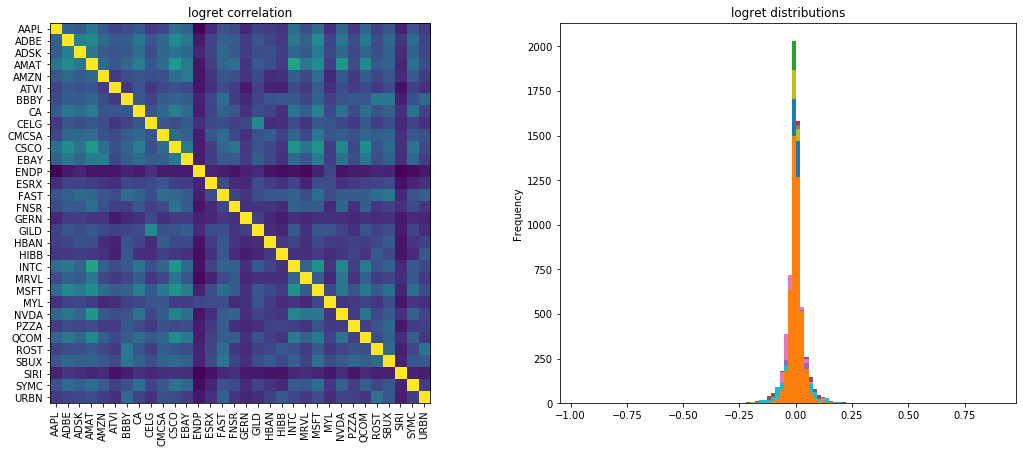

In [6]:
### PLOT RAW LOG RETURN STATISTICS ###

plt.figure(figsize=(18,7))

plt.subplot(121)
plt.imshow(df_logret.T.corr())
plt.xticks(range(df_logret.shape[0]), df_logret.index, rotation=90)
plt.yticks(range(df_logret.shape[0]), df_logret.index)
plt.title('logret correlation')

plt.subplot(122)
df_logret.T.plot.hist(bins=100, legend=False, ax=plt.gca(), title='logret distributions')

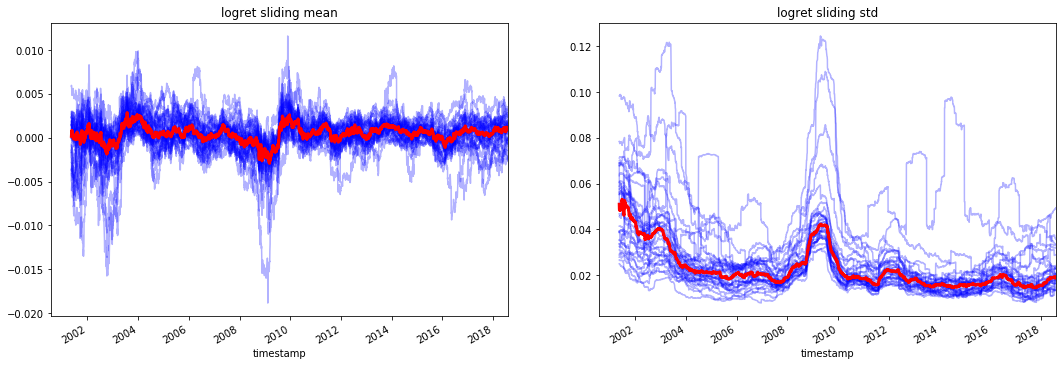

In [7]:
### PLOT LOG RETURN SLIDING STATISTICS ###

plt.figure(figsize=(18,6))

plt.subplot(121)
df_logret.T.rolling(sequence_length).mean().plot(legend=False, color='blue', alpha=0.3, ax=plt.gca(), 
                                                 title='logret sliding mean')
df_logret.T.rolling(sequence_length).mean().median(axis=1).plot(color='red', linewidth=3, ax=plt.gca())

plt.subplot(122)
df_logret.T.rolling(sequence_length).std().plot(legend=False, color='blue', alpha=0.3, ax=plt.gca(), 
                                                title='logret sliding std')
df_logret.T.rolling(sequence_length).std().median(axis=1).plot(color='red', linewidth=3, ax=plt.gca())

In [8]:
### DEFINE UTILITY FUNCTIONS FOR STRUCTURAL ENTROPY CALCULATION ###

def get_timespan(df, start, end):
                                    
    return df.iloc[:,start:end].T

def corr_matrix(df, start, end):
    
    seq = get_timespan(df, start, end)
    corr_seq = seq.corr().values
    
    return corr_seq

def structural_entropy(df_logret, sequence_length, t):
    
    structural_entropy = {'timestamp':[], 'structural_entropy':[]}

    for d in tqdm(range(sequence_length, df_logret.shape[1])):

        _corr = corr_matrix(df_logret, d-sequence_length, d)

        _corr = (np.abs(_corr)>t).astype(int)
        _, _labels = connected_components(_corr)

        _, _count = np.unique(_labels, return_counts=True)
        _countnorm = _count / _count.sum()
        _entropy = -(_countnorm*np.log2(_countnorm)).sum()

        structural_entropy['timestamp'].append(df_logret.columns[d])
        structural_entropy['structural_entropy'].append(_entropy)

    structural_entropy = pd.Series(structural_entropy['structural_entropy'], 
                                   index=structural_entropy['timestamp'])
    
    return structural_entropy

In [9]:
### CALCULATE STRUCTURAL ENTROPY WITH VARIOUS THRESHOLDS TO CREATE ADJACENT MATRIXES ###

structural_entropy_05 = structural_entropy(df_logret, sequence_length, 0.5)
structural_entropy_06 = structural_entropy(df_logret, sequence_length, 0.6)
structural_entropy_07 = structural_entropy(df_logret, sequence_length, 0.7)
structural_entropy_08 = structural_entropy(df_logret, sequence_length, 0.8)

100%|█████████████████████████████████████████████████████████████████████████████| 4330/4330 [00:10<00:00, 397.34it/s]


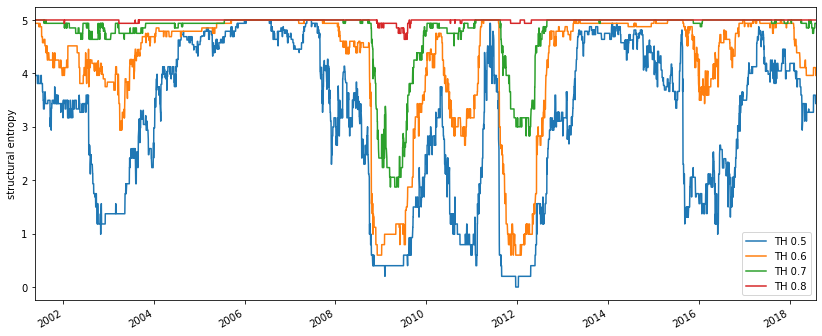

In [10]:
### PLOT STRUCTURAL ENTROPY WITH VARIOUS THRESHOLDS TO CREATE ADJACENT MATRIXES ###

plt.figure(figsize=(14,6))

structural_entropy_05.plot(label='TH 0.5')
structural_entropy_06.plot(label='TH 0.6')
structural_entropy_07.plot(label='TH 0.7')
structural_entropy_08.plot(label='TH 0.8')

plt.ylabel('structural entropy'); plt.legend()

In [11]:
### EXPLORE EDGE CASES IN STRUCTURAL ENTROPY CALCULATION ###

reference_entropy = structural_entropy_06.copy()

id_max = np.random.choice(
    np.where(reference_entropy == reference_entropy.max())[0]
) + sequence_length

id_mean = np.random.choice(
    np.where(reference_entropy.round(1) == round((reference_entropy.max() + 
                                                  reference_entropy.min())/2, 1))[0]
) + sequence_length

id_min = np.random.choice(
    np.where(reference_entropy == reference_entropy.min())[0]
) + sequence_length


df_logret.columns[id_min], df_logret.columns[id_mean], df_logret.columns[id_max]

(Timestamp('2008-12-04 00:00:00'),
 Timestamp('2010-10-12 00:00:00'),
 Timestamp('2015-06-03 00:00:00'))

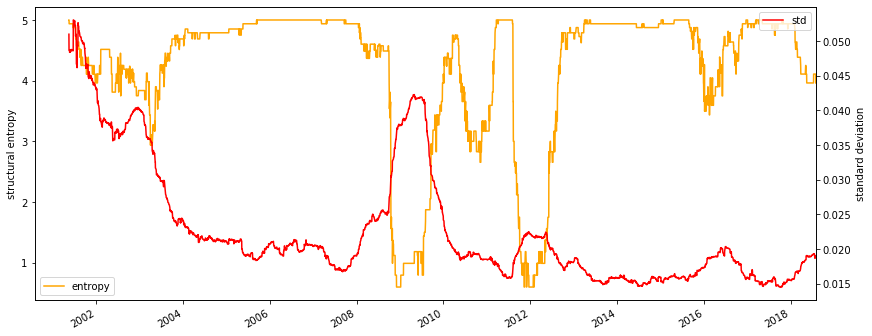

In [12]:
### COMPARE STRUCTURAL ENTROPY AND VOLATILITY ###

plt.figure(figsize=(14,6))

reference_entropy.plot(label='entropy', color='orange')
plt.ylabel('structural entropy')
plt.legend()

plt.twinx()
df_logret.T.rolling(sequence_length).std().median(axis=1).plot(label='std', color='red')
plt.ylabel('standard deviation')

plt.legend()

In [13]:
### UTILITY FUNCTION TO PLOT CORRELATION MATRIX NETWORK ###

def create_graph_corr(df_logret, id_, sequence_length, 
                      thresh_cluster, thresh_edge):
    
    _corr = corr_matrix(df_logret, id_-sequence_length, id_)
    _pca = PCA(n_components=2, random_state=33).fit_transform(_corr)
    
    clusters = (np.abs(_corr)>=thresh_cluster).astype(int)
    _, _labels = connected_components(clusters)
    
    results = dict()
    
    results['edges'] = [(x,y) for x,y in zip(*np.where(np.abs(_corr)>=thresh_edge))]
    results['pos'] = {i:(_pca[i,0], _pca[i,1]) for i in range(len(_labels))}
    results['node_color'] = _labels
    results['nodelist'] = range(len(_labels))
    
    return results

Text(0.5, 1.0, 'max structural entropy')

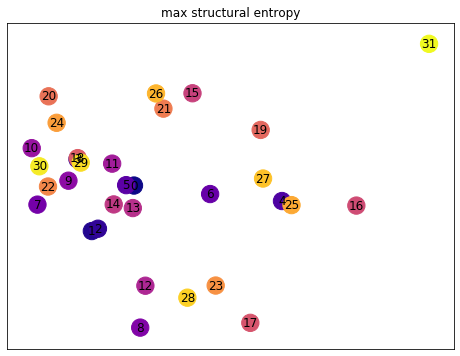

In [14]:
### PLOT A NETWORK WITH MAX STRUCTURAL ENTROPY ###

graph_param = create_graph_corr(df_logret, id_max, sequence_length, 
                                thresh_cluster=0.6, thresh_edge=0.7)
G = nx.Graph()
G.add_edges_from(graph_param['edges'])
del graph_param['edges']

plt.figure(figsize=(8,6))
nx.draw_networkx(G, **graph_param, cmap='plasma')
plt.title('max structural entropy')

Text(0.5, 1.0, 'medium structural entropy')

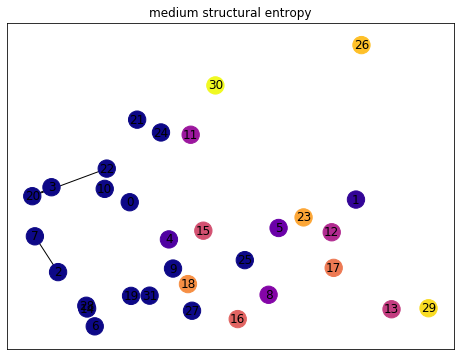

In [15]:
### PLOT A NETWORK WITH MEDIUM STRUCTURAL ENTROPY ###

graph_param = create_graph_corr(df_logret, id_mean, sequence_length, 
                                thresh_cluster=0.6, thresh_edge=0.7)
G = nx.Graph()
G.add_edges_from(graph_param['edges'])
del graph_param['edges']

plt.figure(figsize=(8,6))
nx.draw_networkx(G, **graph_param, cmap='plasma')
plt.title('medium structural entropy')

Text(0.5, 1.0, 'min structural entropy')

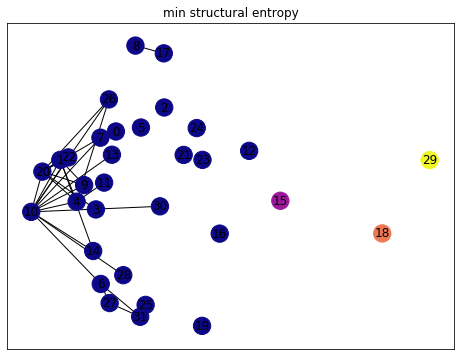

In [16]:
### PLOT A NETWORK WITH MIN STRUCTURAL ENTROPY ###

graph_param = create_graph_corr(df_logret, id_min, sequence_length, 
                             thresh_cluster=0.6, thresh_edge=0.7)
G = nx.Graph()
G.add_edges_from(graph_param['edges'])
del graph_param['edges']

plt.figure(figsize=(8,6))
nx.draw_networkx(G, **graph_param, cmap='plasma')
plt.title('min structural entropy')